In [1]:
import json
import os
import pickle
from abc import abstractmethod

import librosa as librosa
import pandas as pd
import torch
from enum import Enum
import typing as tp
from dataclasses import dataclass
import numpy as np
import torchaudio
from sklearn.metrics import accuracy_score
import sklearn
from torch.nn.functional import cross_entropy
from sklearn.model_selection import train_test_split
from ex2.Ex2.genre_classifier import Genre
import json
import pandas as pd
import librosa
from multiprocessing import Pool
ROOT = ""


In [78]:
import numpy as np
import librosa

def extract_features(wavs):
    all_features = []

    for wav in wavs:
        # Calculate MFCC
        mfccs = librosa.feature.mfcc(y=wav, sr=22050, n_mfcc=13)

        # Calculate spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=wav, sr=22050)

        # Calculate chroma features
        chroma_stft = librosa.feature.chroma_stft(y=wav, sr=22050)

        # Calculate tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(wav), sr=22050)

        # Stack and transpose for correct dimensions
        features = np.vstack([mfccs, spectral_contrast, chroma_stft, tonnetz]).T

        # Calculate mean and standard deviation for each feature
        feature_stats = np.hstack([np.mean(features, axis=0), np.std(features, axis=0)])

        all_features.append(feature_stats)

    return np.array(all_features)

def softmax(z):
    e_z = torch.exp(z - torch.max(z))
    return e_z / e_z.sum(axis=1, keepdims=True)

class LogisticRegressor:
    def __init__(self, input_dim, num_classes):
        self.weights = torch.random.randn(input_dim, num_classes)
        self.bias = torch.random.randn(num_classes)

    def forward(self, feats):
        z = torch.mm(feats, self.weights) + self.bias
        return softmax(z)

    def compute_gradients(self, feats, output_scores, labels):
        num_samples = feats.shape[0]
        output_scores[range(num_samples), labels] -= 1
        output_scores /= num_samples

        grad_weights = torch.mm(feats.T, output_scores)
        grad_bias = torch.sum(output_scores, dim=0)

        return grad_weights, grad_bias

    def update_weights(self, grad_weights, grad_bias, lr):
        self.weights -= lr * grad_weights
        self.bias -= lr * grad_bias

    def train(self, feats, labels, epochs=100, lr=0.01):
        for epoch in range(epochs):
            print(f"Epoch: {epoch}")
            output_scores = self.forward(feats)

            grad_weights, grad_bias = self.compute_gradients(feats, output_scores.copy(), labels)

            self.update_weights(grad_weights, grad_bias, lr)
            # print output scores and loss
            if epoch % 1 == 0:
                loss = cross_entropy(output_scores, labels)
                print(f"Epoch: {epoch}, Loss: {loss}")

    def predict(self, feats):
        output_scores = self.forward(feats)
        return torch.argmax(output_scores, dim=1)

def train_and_test_model(wavs, labels, features=None, epochs=100, lr=0.01):
    # extract features
    if features is None:
        features = extract_features(wavs)

    # normalize features
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # create and train the model
    model = LogisticRegressor(X_train.shape[1], len(np.unique(labels)))
    model.train(X_train, y_train, epochs, lr)

    # test the model
    predictions = model.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    print(f"Test accuracy: {accuracy * 100:.2f}%")

    return model


In [43]:

# Function to load a single wave file
def load_wav_file(item):
    path = item['path']
    label = item['label']
    label = str.replace(label, '-', '_')
    label = Genre[label.upper()].value
    audio, sr = librosa.load(path, sr=None)
    return label, audio, sr

def load_wav_files_parallel(json_file_path):
    # Read the JSON file
    with open(json_file_path) as json_file:
        data = json.load(json_file)

    # Use a multiprocessing Pool to load the wave files in parallel
    with Pool() as p:
        results = p.map(load_wav_file, data)

    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['label', 'audio', 'sr'])

    df = df.sample(frac=1).reset_index(drop=True)
    return df

def load_wav_files(json_file_path):
    # Read the JSON file
    with open(json_file_path) as json_file:
        data = json.load(json_file)

    # Create an empty DataFrame
    df = pd.DataFrame(columns=['label', 'audio', 'sr'])

    # Iterate over first 50 items in the JSON data
    for item in data:
        path = item['path']
        label = item['label']
        label = str.replace(label, '-', '_')
        label = Genre[label.upper()].value
        # Load the audio file using librosa
        audio, sr = librosa.load(path, sr=None)

        # Append the path, label, and audio to the DataFrameu78yt6r5fe4
        df = df.append({'label': label, 'audio': audio, 'sr': sr}, ignore_index=True)

    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [10]:
train_data = load_wav_files(ROOT + 'jsons/train.json')

In [5]:
test_data = load_wav_files(ROOT + 'jsons/test.json')

In [62]:
data = np.array(train_data['audio'])
labels = np.array(train_data['label'], dtype=int)

In [16]:
def exctract_feats(wavs: torch.Tensor):
    """
    this function extract features from a given audio.
    we will not be observing this method.
    """
    ## features extraction
    features_list = []
    batch_size = wavs.size()[0]
    data = wavs.numpy()
    # first family - crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data)
    avg_zero_crossing_rate = np.mean(zero_crossing_rate, axis=(1, 2))
    std_zero_crossing_rate = np.std(zero_crossing_rate, axis=(1, 2))
    features_list.append(torch.tensor(avg_zero_crossing_rate, dtype=torch.float32).view(batch_size, 1))
    features_list.append(torch.tensor(std_zero_crossing_rate, dtype=torch.float32).view(batch_size, 1))
    # print("zero crossing rate: ", zero_crossing_rate.shape, avg_zero_crossing_rate.shape,
    #       std_zero_crossing_rate.shape)

    # second family - spectral
    spectral_centroid = librosa.feature.spectral_centroid(y=data)
    avg_spectral_centroid = np.mean(spectral_centroid, axis=(1, 2))
    std_spectral_centroid = np.std(spectral_centroid, axis=(1, 2))
    # print("spectral centroid: ", spectral_centroid.shape, avg_spectral_centroid.shape,
    #       std_spectral_centroid.shape)
    features_list.append(torch.tensor(avg_spectral_centroid, dtype=torch.float32).view(batch_size, 1))
    features_list.append(torch.tensor(std_spectral_centroid, dtype=torch.float32).view(batch_size, 1))

    # third family - spectral contrast
    # spectral_contrast = librosa.feature.spectral_contrast(y=data)
    # avg_spectral_contrast = np.mean(spectral_contrast, axis=(1, 2))
    # std_spectral_contrast = np.std(spectral_contrast, axis=(1, 2))
    # # print("spectral contrast: ", spectral_contrast.shape, avg_spectral_contrast.shape,
    # #       std_spectral_contrast.shape)
    # features_list.append(torch.tensor(avg_spectral_contrast, dtype=torch.float32).view(batch_size, 1))
    # features_list.append(torch.tensor(std_spectral_contrast, dtype=torch.float32).view(batch_size, 1))

    # forth family - log RMS
    log_rms = librosa.feature.rms(y=librosa.amplitude_to_db(abs(data)))
    avg_log_rms = np.mean(log_rms, axis=(1, 2))
    std_log_rms = np.std(log_rms, axis=(1, 2))
    # print("log RMS: ", log_rms.shape, avg_log_rms.shape, std_log_rms.shape)
    features_list.append(torch.tensor(avg_log_rms, dtype=torch.float32).view(batch_size, 1))
    features_list.append(torch.tensor(std_log_rms, dtype=torch.float32).view(batch_size, 1))

    # # fifth family MFCC features
    mfcc = librosa.feature.mfcc(y=data, n_mfcc=13)
    # Padding first and second deltas
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    zero_order_mfcc = np.mean(mfcc, axis=2)
    first_order_mfcc = np.mean(delta_mfcc, axis=2)
    second_order_mfcc = np.mean(delta2_mfcc, axis=2)

    # print("MFCC: ", mfcc.shape, zero_order_mfcc.shape, first_order_mfcc.shape, second_order_mfcc.shape)
    features_list.append(torch.tensor(zero_order_mfcc, dtype=torch.float32).view(batch_size, 13))
    features_list.append(torch.tensor(first_order_mfcc, dtype=torch.float32).view(batch_size, 13))
    features_list.append(torch.tensor(second_order_mfcc, dtype=torch.float32).view(batch_size, 13))

    # sixth family - chroma
    # chroma = librosa.feature.chroma_stft(y=data)
    # avg_chroma = np.mean(chroma, axis=(1, 2))
    # std_chroma = np.std(chroma, axis=(1, 2))
    # # print("chroma: ", chroma.shape, avg_chroma.shape, std_chroma.shape)
    # features_list.append(torch.tensor(avg_chroma, dtype=torch.float32).view(batch_size, 1))
    # features_list.append(torch.tensor(std_chroma, dtype=torch.float32).view(batch_size, 1))

    # seventh family - tonnetz
    # tonnetz = librosa.feature.tonnetz(y=data)
    # avg_tonnetz = np.mean(tonnetz, axis=(1, 2))
    # std_tonnetz = np.std(tonnetz, axis=(1, 2))
    # # print("tonnetz: ", tonnetz.shape, avg_tonnetz.shape, std_tonnetz.shape)
    # features_list.append(torch.tensor(avg_tonnetz, dtype=torch.float32).view(batch_size, 1))
    # features_list.append(torch.tensor(std_tonnetz, dtype=torch.float32).view(batch_size, 1))

    # eigth - spectral flatness, rolloff, bandwidth
    spectral_flatness = librosa.feature.spectral_flatness(y=data)
    avg_spectral_flatness = np.mean(spectral_flatness, axis=(1, 2))
    std_spectral_flatness = np.std(spectral_flatness, axis=(1, 2))
    # print("spectral flatness: ", spectral_flatness.shape, avg_spectral_flatness.shape,
    #       std_spectral_flatness.shape)
    features_list.append(torch.tensor(avg_spectral_flatness, dtype=torch.float32).view(batch_size, 1))
    features_list.append(torch.tensor(std_spectral_flatness, dtype=torch.float32).view(batch_size, 1))

    spectral_rolloff = librosa.feature.spectral_rolloff(y=data)
    avg_spectral_rolloff = np.mean(spectral_rolloff, axis=(1, 2))
    std_spectral_rolloff = np.std(spectral_rolloff, axis=(1, 2))
    # print("spectral rolloff: ", spectral_rolloff.shape, avg_spectral_rolloff.shape,
    #       std_spectral_rolloff.shape)
    features_list.append(torch.tensor(avg_spectral_rolloff, dtype=torch.float32).view(batch_size, 1))
    features_list.append(torch.tensor(std_spectral_rolloff, dtype=torch.float32).view(batch_size, 1))

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data)
    avg_spectral_bandwidth = np.mean(spectral_bandwidth, axis=(1, 2))
    std_spectral_bandwidth = np.std(spectral_bandwidth, axis=(1, 2))
    # print("spectral bandwidth: ", spectral_bandwidth.shape, avg_spectral_bandwidth.shape,
    #       std_spectral_bandwidth.shape)
    features_list.append(torch.tensor(avg_spectral_bandwidth, dtype=torch.float32).view(batch_size, 1))
    features_list.append(torch.tensor(std_spectral_bandwidth, dtype=torch.float32).view(batch_size, 1))


    features = torch.cat(features_list, dim=1)

    return features

In [49]:
def exctract_features_batch(wavs, batch_size):# extract features by batches
    for batch in range(0, len(wavs), batch_size):
        print("batch: ", batch)
        batch_data = wavs[batch:batch + batch_size]
        batch_features = exctract_feats(batch_data)
        if batch == 0:
            features = batch_features
        else:
            features = torch.cat((features, batch_features), dim=0)
        print("features: ", features.shape)
    return features

In [40]:
n_data = np.asarray(data.tolist())
t_data = torch.tensor(n_data, dtype=torch.float32)

In [51]:
features = exctract_features_batch(t_data[:200], 100)

batch:  0
features:  torch.Size([100, 51])
batch:  100
features:  torch.Size([200, 51])


In [155]:
features.shape

(51,)

In [80]:
train_and_test_model(n_data[:20], labels[:20], features[:20].numpy())

AttributeError: module 'torch.random' has no attribute 'randn'

In [146]:
class LogisticRegressor:
    def __init__(self, input_dim: int, num_classes: int):
        self.weights = torch.randn(input_dim, num_classes, requires_grad=True)
        self.bias = torch.randn(num_classes, requires_grad=True)

    def forward(self, feats: torch.Tensor) -> torch.Tensor:
        return torch.mm(feats, self.weights) + self.bias

    def backward(self, feats: torch.Tensor, output_scores: torch.Tensor, labels: torch.Tensor):
        loss = torch.nn.functional.cross_entropy(output_scores, labels)
        loss.backward()

        with torch.no_grad():
            self.weights -= 0.01 * self.weights.grad
            self.bias -= 0.01 * self.bias.grad

            # zero the gradients after updating
            self.weights.grad.zero_()
            self.bias.grad.zero_()

    def extract_feats(self, wavs: torch.Tensor):
        # insert your feature extraction logic here
        pass


from sklearn.model_selection import train_test_split
import torch


def train_and_test_model(features: np.ndarray, labels: np.ndarray, epochs = 100):
    # convert features and labels to torch tensors
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)

    # split the features and labels into a training set and a testing set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    print(y_train.shape)
    # get the number of features from the feature data
    input_dim = X_train.shape[1]

    # get the number of unique classes from the labels
    num_classes = len(torch.unique(labels))

    # create the model
    model = LogisticRegressor(input_dim, num_classes)

    # training loop
    print(epochs)
    for epoch in range(epochs):
        # forward pass
        output_scores = model.forward(X_train)

        # backward pass and optimization
        model.backward(X_train, output_scores, y_train)

        # print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            loss = torch.nn.functional.cross_entropy(output_scores, y_train)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    # testing the model
    test_output_scores = model.forward(X_test)
    _, predicted = torch.max(test_output_scores.data, 1)
    correct = (predicted == y_test).sum().item()
    test_accuracy = correct / len(y_test)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

    return model


In [154]:
model = train_and_test_model(features[:100], labels[:100], 100)

ValueError: Found input variables with inconsistent numbers of samples: [51, 100]

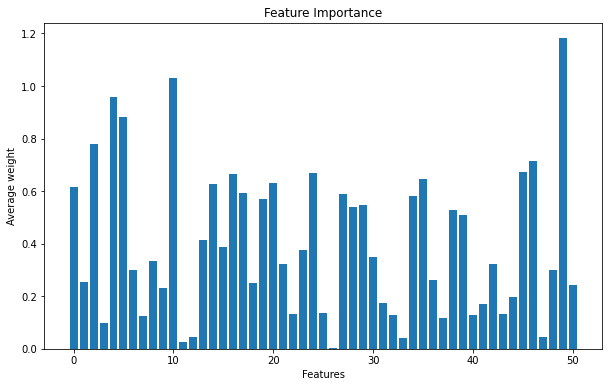

In [145]:
import matplotlib.pyplot as plt

# Assuming that your trained model is 'model'
# and your features are ['MFCC', 'Spectral contrast', 'Chroma features', 'Tonnetz']

# Extract weights
weights = model.weights.detach().numpy()

# Average weights across output classes
average_weights = np.mean(weights, axis=1)

# Feature names
features = np.arange(0, 51)

plt.figure(figsize=(10, 6))
plt.bar(features, abs(average_weights))
plt.xlabel('Features')
plt.ylabel('Average weight')
plt.title('Feature Importance')
plt.show()

